In [127]:
import os, sys
sys.path.append("C:/Users/piyalong/CrowdCounting-P2PNet/")

import argparse
import datetime
import random
import time
from pathlib import Path

import torch
import torchvision.transforms as standard_transforms
import numpy as np

from PIL import Image
import cv2
from crowd_datasets import build_dataset
from engine import *
from models import build_model

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline
torch.cuda.empty_cache() 
import json
from matplotlib.patches import Circle
import pandas as pd



10


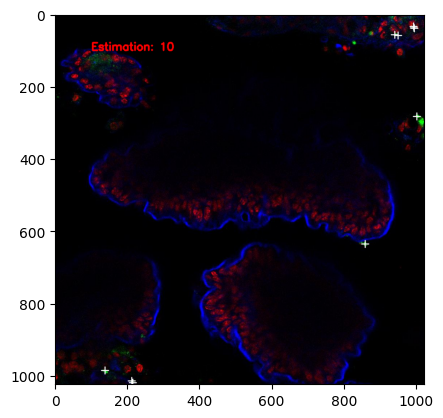

In [83]:
class Args():
    backbone='vgg16_bn'
    gpu_id=0
    img_path='D:/Osiris_tepm_file-20230330T190410Z-001/Osiris_tepm_file/WT-1_ID_PIC-1_JOA97_59.jpg'
    line=2
    output_dir='output'
    row=2
    weight_path='C:/Users/piyalong/CrowdCounting-P2PNet/ckpt/best_mae.pth'

args=Args()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch. set_grad_enabled(False)
# def main(args, debug=False):

#     os.environ["CUDA_VISIBLE_DEVICES"] = '{}'.format(args.gpu_id)

print(args)
# device = torch.device('cpu')
# get the P2PNet
model = build_model(args)
# move to GPU
model.to(device)
# load trained model
if args.weight_path is not None:
    checkpoint = torch.load(args.weight_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
# convert to eval mode
model.eval()
# create the pre-processing transform
transform = standard_transforms.Compose([
    standard_transforms.ToTensor(), 
    standard_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# set your image path here
img_path = args.img_path
# load the images
img_raw = Image.open(img_path).convert('RGB')
# round the size
# width, height = img_raw.size
# new_width = width // 128 * 128
# new_height = height // 128 * 128
# img_raw = img_raw.resize((new_width, new_height), Image.ANTIALIAS)
# pre-proccessing
img = transform(img_raw)

samples = torch.Tensor(img).unsqueeze(0)
samples = samples.to(device)
# run inference
outputs = model(samples)
outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]

outputs_points = outputs['pred_points'][0]

threshold = 0.05
# filter the predictions
points = outputs_points[outputs_scores > threshold].detach().cpu().numpy().tolist()
predict_cnt = int((outputs_scores > threshold).sum())
scores= outputs_scores[outputs_scores > threshold]
outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]

outputs_points = outputs['pred_points'][0]
# draw the predictions
size = 4
img_to_draw = cv2.cvtColor(np.array(img_raw), cv2.COLOR_RGB2BGR)

img_to_draw = cv2.putText(img_to_draw,"Estimation: "+str(len(points)), (100,100), cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 3)
print(len(points))
for p in points:
    # img_to_draw = cv2.circle(img_to_draw, (int(p[0]), int(p[1])), size, (0, 0, 255), -1)
    cv2.drawMarker(img_to_draw, (int(p[0]), int(p[1])), (255, 255, 255), cv2.MARKER_CROSS, markerSize=20,thickness=2)
    
# cv2.rectangle(img_to_draw, (100, 100), (120, 140), (255,255,255), 2)
# save the visualized image
# cv2.imshow('ImageWindow',img_to_draw)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

cv2.imwrite(os.path.join(args.output_dir, 'pred{}.jpg'.format(predict_cnt)), img_to_draw)

img_to_draw = cv2.cvtColor(img_to_draw, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()

plt.imshow(img_to_draw)

In [84]:
import re


141 992
216 1022
245 892
1005 285
829 77
872 56
937 6
941 57
996 37
858 637
1018 337
1010 297
166 937
158 142


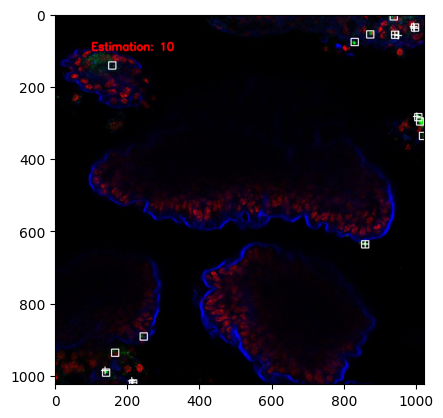

In [85]:
ground_truth_pixel_points=[]

xml_file = img_path[:-7]+".txt"
with open(xml_file) as file:
    for pt in file.readlines():
        # print(pt.strip().split(","))
        x,y=pt.split(",")
        numbersx = re.findall('\d+', x)[0]
        numbersy = re.findall('\d+', y)[0]
        print(int(numbersx),int(numbersy))
        ground_truth_pixel_points.append([int(numbersx),int(numbersy)])
        cv2.drawMarker(img_to_draw, (int(numbersx),int(numbersy)), (255, 255, 255), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
plt.imshow(img_to_draw)


In [86]:
from scipy.optimize import linear_sum_assignment
import numpy as np
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Example pixel point coordinates
predicted_points=np.array(points).astype(int)

gt_points = np.array(ground_truth_pixel_points)

# print(ground_truth_pixel_points.shape,predicted_pixel_points.shape)


6 14 10


Text(0.5, 1.0, 'Recall: 42.86% Precision: 60.00%')

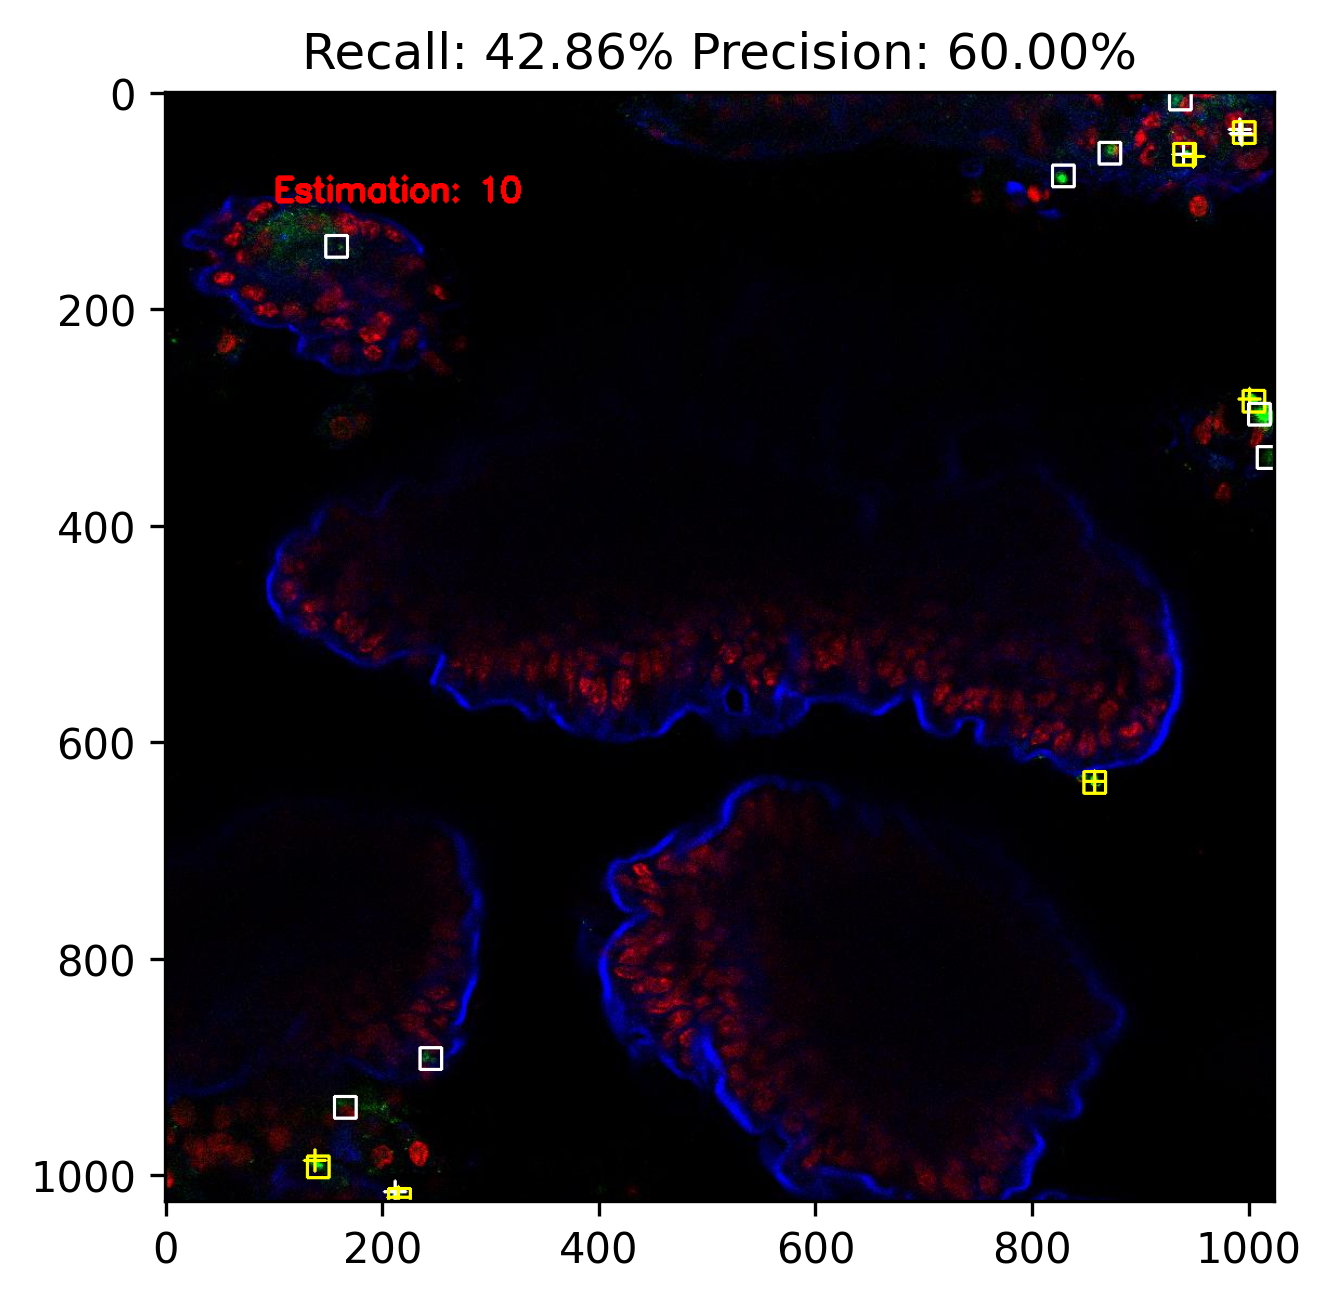

In [87]:
def create_cost_matrix(predicted_points, gt_points, dummy_cost):
    n_points_pred = len(predicted_points)
    n_points_gt = len(gt_points)

    if n_points_pred >= n_points_gt:
        n_rows = n_points_pred
        n_cols = n_points_pred
        n_dummy_points = n_points_pred - n_points_gt
    else:
        n_rows = n_points_gt
        n_cols = n_points_gt
        n_dummy_points = n_points_gt - n_points_pred

    cost_matrix = np.zeros((n_rows, n_cols))

    for i, pred_point in enumerate(predicted_points):
        for j, gt_point in enumerate(gt_points):
            cost_matrix[i, j] = euclidean_distance(pred_point, gt_point)

    for i in range(n_points_pred, n_rows):
        for j in range(n_points_gt, n_cols):
            cost_matrix[i, j] = dummy_cost

    return cost_matrix

plt.figure(dpi=300)

dummy_cost=1e6
# def match_points(predicted_points, gt_points, dummy_cost=1e6):
cost_matrix = create_cost_matrix(predicted_points, gt_points, dummy_cost)
row_indices, col_indices = linear_sum_assignment(cost_matrix)
# image_path = 'C:/Users/piyalong/Pictures/20230323.jpg'
# annotations_path = 'D:/via_project_23Mar2023_10h8m_json.json'
# visualize_point_annotations(image_path, annotations_path)
image=img_to_draw
# image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
n_points_pred = len(predicted_points)
n_points_gt = len(gt_points)
total_cost = cost_matrix[row_indices, col_indices].sum() - abs(n_points_pred - n_points_gt) * dummy_cost
# print(f"Total cost of optimal point assignment: {total_cost}")
a=30
tp=0
for row, col in zip(row_indices, col_indices):
    if row < n_points_pred and col < n_points_gt:
        pred_point = predicted_points[row]
        gt_point = gt_points[col]
        if cost_matrix[row, col]<a:
            # print(pred_point)
            cv2.drawMarker(image, (gt_point), (255, 255, 0), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
            cv2.drawMarker(image, (pred_point), (255, 255, 0), cv2.MARKER_CROSS, markerSize=20,thickness=2)
            tp+=1
        else:
            cv2.drawMarker(image, (gt_point), (255, 255, 255), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
            cv2.drawMarker(image, (pred_point), (255, 255, 255), cv2.MARKER_CROSS, markerSize=20,thickness=2)

        # print(f"Predicted point {row} ({pred_point}) is assigned to ground truth point {col} ({gt_point}) with cost {cost_matrix[row, col]}")
    elif row < n_points_pred:
        pred_point = predicted_points[row]
        # print(f"Predicted point {row} ({pred_point}) is not assigned to any ground truth point")
        cv2.drawMarker(image, (pred_point), (255, 255, 255), cv2.MARKER_CROSS, markerSize=20,thickness=2)
    else:
        gt_point = gt_points[col]
        # print(f"Ground truth point {col} ({gt_point}) is not assigned to any predicted point")
        cv2.drawMarker(image, (gt_point), (255, 255, 255), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
plt.imshow(image)
print(tp,n_points_gt,n_points_pred)
plt.title('Recall: {0:.2%} Precision: {1:.2%}'.format(tp/n_points_gt,tp/n_points_pred))

    
# match_points(predicted_pixel_points, ground_truth_pixel_points)


# Process all data

In [158]:
def evaluate(img_path,    threshold = 0.05):
    # img_path = args.img_path
    # load the images
    img_raw = Image.open(img_path).convert('RGB')
    # round the size
    # width, height = img_raw.size
    # new_width = width // 128 * 128
    # new_height = height // 128 * 128
    # img_raw = img_raw.resize((new_width, new_height), Image.ANTIALIAS)
    # pre-proccessing
    img = transform(img_raw)

    samples = torch.Tensor(img).unsqueeze(0)
    samples = samples.to(device)
    # run inference
    outputs = model(samples)
    outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]

    outputs_points = outputs['pred_points'][0]

    # filter the predictions
    points = outputs_points[outputs_scores > threshold].detach().cpu().numpy().tolist()
    predict_cnt = int((outputs_scores > threshold).sum())
    scores= outputs_scores[outputs_scores > threshold]
    outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]

    outputs_points = outputs['pred_points'][0]
    # draw the predictions
    size = 4
#     img_to_draw = cv2.cvtColor(np.array(img_raw), cv2.COLOR_RGB2BGR)

#     img_to_draw = cv2.putText(img_to_draw,"Estimation: "+str(len(points)), (100,100), cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 3)
    for p in points:
        # img_to_draw = cv2.circle(img_to_draw, (int(p[0]), int(p[1])), size, (0, 0, 255), -1)
        cv2.drawMarker(img_to_draw, (int(p[0]), int(p[1])), (255, 255, 255), cv2.MARKER_CROSS, markerSize=20,thickness=2)
    
    ground_truth_pixel_points=[]

    xml_file = img_path[:-7]+".txt"
    with open(xml_file) as file:
        for pt in file.readlines():
            # print(pt.strip().split(","))
            x,y=pt.split(",")
            numbersx = re.findall('\d+', x)[0]
            numbersy = re.findall('\d+', y)[0]
            # print(int(numbersx),int(numbersy))
            ground_truth_pixel_points.append([int(numbersx),int(numbersy)])
    
    # Example pixel point coordinates
    predicted_points=np.array(points).astype(int)

    gt_points = np.array(ground_truth_pixel_points)

    # print("Prediction: {} Ground Truth: {}".format(len(predicted_points),len(gt_points)))
    dummy_cost=1e6
    # def match_points(predicted_points, gt_points, dummy_cost=1e6):
    cost_matrix = create_cost_matrix(predicted_points, gt_points, dummy_cost)
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    # image_path = 'C:/Users/piyalong/Pictures/20230323.jpg'
    # annotations_path = 'D:/via_project_23Mar2023_10h8m_json.json'
    # visualize_point_annotations(image_path, annotations_path)
    image=img_to_draw
    # image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    n_points_pred = len(predicted_points)
    n_points_gt = len(gt_points)
    total_cost = cost_matrix[row_indices, col_indices].sum() - abs(n_points_pred - n_points_gt) * dummy_cost
    # print(f"Total cost of optimal point assignment: {total_cost}")
    a=28.28
    tp=0
    for row, col in zip(row_indices, col_indices):
        if row < n_points_pred and col < n_points_gt:
            pred_point = predicted_points[row]
            gt_point = gt_points[col]
            if cost_matrix[row, col]<a:
                # print(pred_point)
                cv2.drawMarker(image, (gt_point), (255, 255, 0), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
                cv2.drawMarker(image, (pred_point), (255, 255, 0), cv2.MARKER_CROSS, markerSize=20,thickness=2)
                tp+=1

    return tp,n_points_gt,n_points_pred
    
# match_points(predicted_pixel_points, ground_truth_pixel_points)


In [ ]:
results=[]
folder="D:/Osiris_tepm_file-20230330T190410Z-001/Osiris_tepm_file/"
for image_path in os.listdir(folder):
    if image_path.endswith('jpg'):
        img_path = os.path.join(folder,image_path)
        # print(img_path)

        tp,n_points_gt,n_points_pred=evaluate(img_path)
        results.append([tp,n_points_gt,n_points_pred])
sum_result = pd.DataFrame(results).sum(axis=0)
# sensitivity.append([threshold,sum_result[0]/sum_result[1],sum_result[0]/sum_result[2]])
print('Recall: {0:.2%} Precision: {1:.2%}'.format(sum_result[0]/sum_result[1],sum_result[0]/sum_result[2]))

Recall: 42.55% Precision: 44.44%


In [160]:
sensitivity=[]
for threshold in np.arange(0.01, 0.21, 0.01):
    results=[]
    folder="D:/Osiris_tepm_file-20230330T190410Z-001/Osiris_tepm_file/"
    for image_path in os.listdir(folder):
        if image_path.endswith('jpg'):
            img_path = os.path.join(folder,image_path)
            # print(img_path)

            tp,n_points_gt,n_points_pred=evaluate(img_path,threshold)
            results.append([tp,n_points_gt,n_points_pred])
    sum_result = pd.DataFrame(results).sum(axis=0)
    sensitivity.append([threshold,sum_result[0]/sum_result[1],sum_result[0]/sum_result[2]])
    print('Recall: {0:.2%} Precision: {1:.2%}'.format(sum_result[0]/sum_result[1],sum_result[0]/sum_result[2]))

Recall: 60.43% Precision: 23.59%
Recall: 53.62% Precision: 32.81%
Recall: 50.21% Precision: 39.20%
Recall: 47.23% Precision: 42.05%
Recall: 42.55% Precision: 44.44%
Recall: 42.13% Precision: 50.25%
Recall: 37.87% Precision: 51.74%
Recall: 36.17% Precision: 52.80%
Recall: 35.32% Precision: 56.08%
Recall: 34.89% Precision: 58.57%
Recall: 33.62% Precision: 58.96%
Recall: 30.64% Precision: 57.60%
Recall: 30.21% Precision: 58.68%
Recall: 30.21% Precision: 60.68%
Recall: 29.36% Precision: 61.06%
Recall: 28.94% Precision: 61.26%
Recall: 28.09% Precision: 61.11%
Recall: 27.66% Precision: 63.73%
Recall: 26.81% Precision: 63.64%
Recall: 27.23% Precision: 65.98%


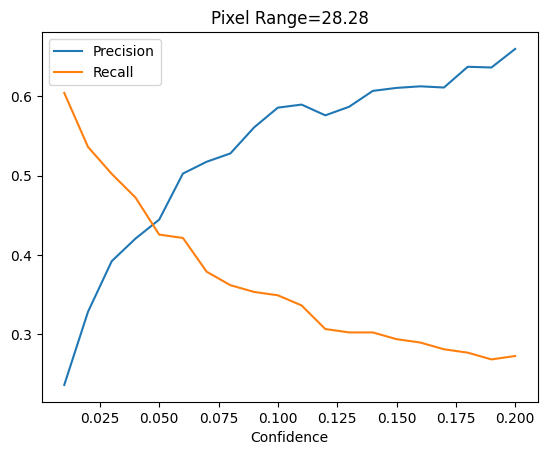

In [174]:
df=pd.DataFrame(sensitivity)
df.columns = ['Thredhold', 'Recall', 'Precision']
plt.plot(df['Thredhold'],df['Precision'],label='Precision')
plt.plot(df['Thredhold'],df['Recall'],label='Recall')
plt.title('Pixel Range={}'.format(str(28.28)))
plt.xlabel("Confidence")
plt.legend()

# Conclusion: 
According to the figure above, the most balanced threhold shoul dbe around 0.05 (for the current model) bearing a Recall: 42.55% Precision: 44.44%. This is not the most exciting result. Still, it is a good start given we only used the ROI files. Transferlearning on the XML files should enhance the model performance and hopefully better results. 